In [1]:
from auto_ml_regression.automl_pipeline import AutoMLPipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import numpy as np
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

data = pd.read_csv('../../datasets/car_prices/LifeExpectancyData.csv')
target_col="Life expectancy "
N_SEGMENTS = 2
cols_to_del = ['Country']
data = data.drop(columns=cols_to_del).dropna(subset=target_col)

cat_features = data.select_dtypes(include='object').columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()
num_features.remove(target_col)
cat_features_saved = [f'CAT_{i}' for i in cat_features]

# Инициализация
pipeline = AutoMLPipeline(
    num_features=num_features,
    cat_features=cat_features,
    target_col=target_col,
    test_size=0.3,
    n_segments=N_SEGMENTS   # Можно указать любое количество сегментов
)

/Users/andrejurkinair/Documents/diploma_practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# График общего распределения целевого признака

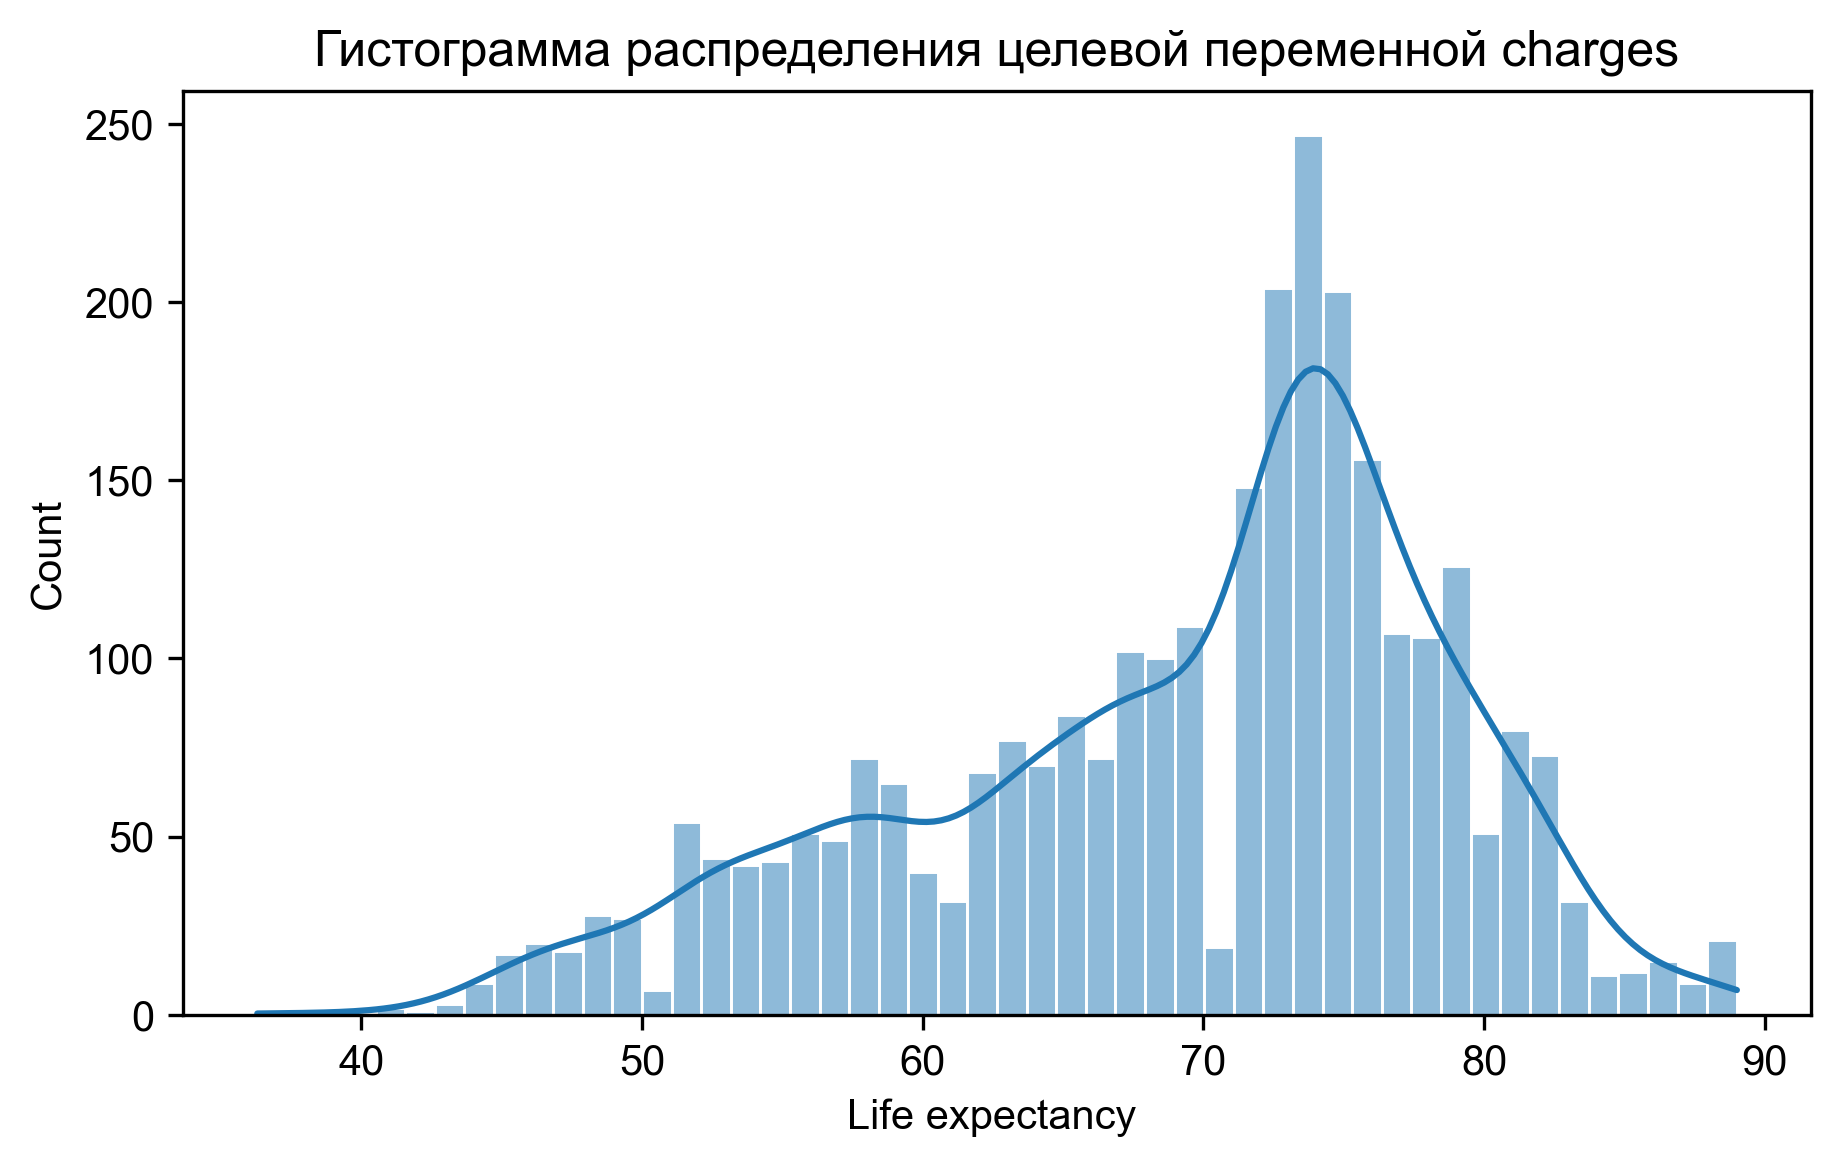

In [2]:
plt.figure(figsize=(7,4), dpi=300)
plt.title("Гистограмма распределения целевой переменной charges")
sns.set_style("whitegrid")
sns.histplot(data[target_col], bins=50, kde=True)
plt.show();

# Предобработка данных

In [8]:
# Запуск полного пайплайна
pipeline.preprocess_data(data)

In [9]:
train_df = pipeline.train_data
test_df = pipeline.test_data

In [10]:
train_df

,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,...,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,CAT_Status,Life expectancy
0,0.066667,0.0,0.186981,0.000000,0.000000,0.001728,0.815927,0.000000,0.679369,0.0000,...,0.828056,0.000000,0.001692,0.000052,0.086957,0.087719,0.000000,0.000000,Developing,73.3
1,0.466667,0.0,0.011080,0.001111,0.426590,0.010754,0.928571,0.000000,0.758213,0.0008,...,0.969072,0.000000,0.013158,0.012746,0.028986,0.028070,0.843386,0.714976,Developing,78.9
2,1.000000,0.0,0.313019,0.006111,0.266177,0.000000,0.989796,0.000005,0.268068,0.0060,...,0.989691,0.005941,0.000585,0.008988,0.202899,0.196491,0.521693,0.521739,Developing,66.1
3,0.266667,1.0,0.094183,0.000000,0.376879,0.010437,0.857143,0.000022,0.834428,0.0000,...,0.896907,0.000000,0.013095,0.000032,0.021739,0.021053,0.843386,0.685990,Developed,78.7
4,0.266667,1.0,0.134349,0.000000,0.650867,0.356718,0.815927,0.000000,0.701708,0.0000,...,0.958763,0.000000,0.401769,0.000421,0.039855,0.031579,0.944974,0.797101,Developed,77.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,0.200000,0.0,0.174515,0.000556,0.031792,0.003370,1.000000,0.000005,0.618922,0.0004,...,1.000000,0.000000,0.008346,0.009865,0.253623,0.235088,0.767196,0.541063,Developing,73.6
2045,0.800000,0.0,0.202216,0.017778,0.000000,0.022057,0.612245,0.000082,0.738502,0.0156,...,0.690722,0.000000,0.057425,0.025332,0.188406,0.175439,0.694180,0.507246,Developing,76.0
2046,0.800000,0.0,0.126039,0.000000,0.265896,0.035617,0.928571,0.000121,0.699080,0.0000,...,0.927835,0.000000,0.040714,0.000028,0.086957,0.084211,0.770370,0.671498,Developing,76.8
2047,0.066667,0.0,0.844875,0.023889,0.150289,0.002404,0.815927,0.093142,0.211564,0.0280,...,0.855670,0.366337,0.003236,0.001410,0.264493,0.256140,0.448677,0.473430,Developing,44.6


# OLS

In [11]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_df[num_features+cat_features], train_df[target_col])

LinearRegression()

In [12]:
from sklearn import metrics

y_true = test_df[target_col]
y_pred = lr.predict(test_df[num_features+cat_features])

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.8258520779371662
MSE = 15.624617377744165
RMSE = 3.952798676601702
MAE = 2.960548908588173
MAPE = 0.045588242762504096


/var/folders/dy/q_kmpbjj54q1glfr1wthxzhw0000gn/T/ipykernel_47855/2350633174.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.scatterplot(


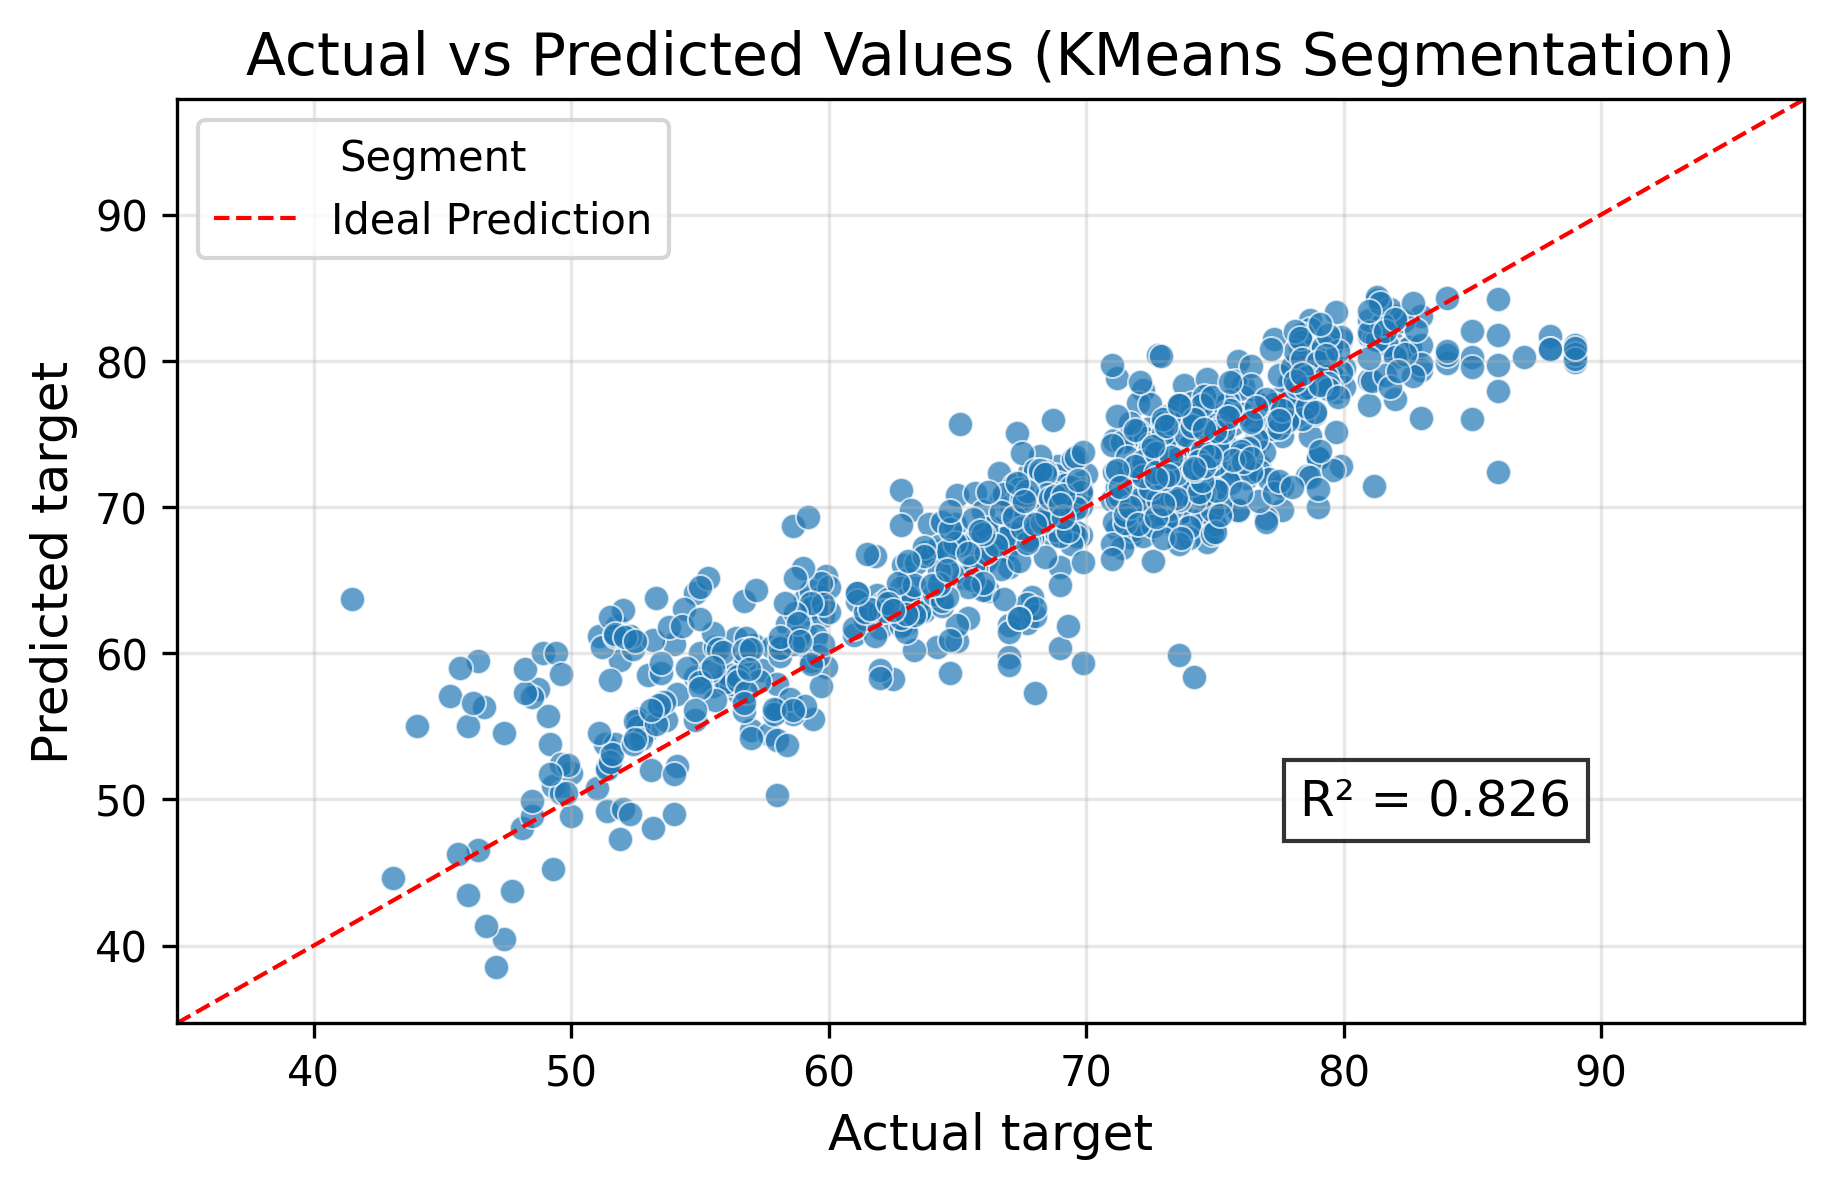

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Предположим, у нас есть:
# y_test - истинные значения на тестовой выборке
# y_pred - предсказания модели CatBoost+KMeans на тестовой выборке
y_test = y_true

# Создаем DataFrame для визуализации
plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,# Добавляем информацию о сегментах
})

# Определяем границы осей (минимальное/максимальное значение + 10%)
ax_min = min(y_test.min(), y_pred.min()) * 0.9
ax_max = max(y_test.max(), y_pred.max()) * 1.1

# Создаем фигуру
plt.figure(figsize=(7, 4), dpi=300)

# Диаграмма рассеяния с цветовым кодированием по сегментам
scatter = sns.scatterplot(
    data=plot_data,
    x='Actual',
    y='Predicted',
    palette='viridis',
    alpha=0.7
)

# Добавляем идеальную линию
ideal_line = plt.plot(
    [ax_min, ax_max],
    [ax_min, ax_max],
    '--',
    color='red',
    linewidth=1,
    label='Ideal Prediction'
)

# Настройки графика
plt.title('Actual vs Predicted Values (KMeans Segmentation)', fontsize=14)
plt.xlabel('Actual target', fontsize=12)
plt.ylabel('Predicted target', fontsize=12)
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.legend(title='Segment')
plt.grid(True, alpha=0.3)

# Добавляем коэффициент R² в аннотацию
r2 = metrics.r2_score(y_test, y_pred)
plt.text(
    x=ax_max*0.8,
    y=ax_max*0.5,
    s=f'R² = {r2:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()

# Huber

In [8]:
# 2. Определяем целевую функцию для Optuna
def objective(trial):
    # Предлагаем Optuna подбирать гиперпараметры
    epsilon = trial.suggest_float("epsilon", 1.0, 3.0, step=0.1)  # Оптимальный диапазон для epsilon
    alpha = trial.suggest_float("alpha", 0.0001, 1.0, log=True)    # Логарифмический масштаб для alpha

    # Создаем модель Huber с текущими гиперпараметрами
    model = HuberRegressor(epsilon=epsilon, alpha=alpha, max_iter=1000)

    # Используем кросс-валидацию (KFold) для оценки
    kf = KFold(n_splits=3, shuffle=True, random_state=2025)
    scores = cross_val_score(model, train_df[num_features+cat_features], train_df[target_col], 
                             cv=kf, scoring=make_scorer(mean_squared_error))
    
    scores_mae = cross_val_score(model, train_df[num_features+cat_features], train_df[target_col], 
                             cv=kf, scoring=make_scorer(mean_absolute_error))

    # Optuna минимизирует значение, поэтому берем средний MSE
    return np.mean(scores) + np.mean(scores_mae)

study = optuna.create_study(direction="minimize")  # Минимизируем MSE
study.optimize(objective, n_trials=50, show_progress_bar=False)
best_params = study.best_params

huber = HuberRegressor(max_iter=1000, **best_params)
huber.fit(train_df[num_features+cat_features], train_df[target_col])

[I 2025-05-20 22:12:20,545] A new study created in memory with name: no-name-44519cab-0a56-456c-bb60-d1d0741d165c
[I 2025-05-20 22:12:21,526] Trial 0 finished with value: 21.019577442665454 and parameters: {'epsilon': 1.3, 'alpha': 0.0026926467688873582}. Best is trial 0 with value: 21.019577442665454.
[I 2025-05-20 22:12:21,985] Trial 1 finished with value: 21.113374396568155 and parameters: {'epsilon': 3.0, 'alpha': 0.08062779397035845}. Best is trial 0 with value: 21.019577442665454.
[I 2025-05-20 22:12:22,459] Trial 2 finished with value: 21.607394206732955 and parameters: {'epsilon': 1.4, 'alpha': 0.08780608665376761}. Best is trial 0 with value: 21.019577442665454.
[I 2025-05-20 22:12:22,677] Trial 3 finished with value: 21.328033098633078 and parameters: {'epsilon': 2.8, 'alpha': 0.6309533108724513}. Best is trial 0 with value: 21.019577442665454.
[I 2025-05-20 22:12:23,453] Trial 4 finished with value: 20.810896856636447 and parameters: {'epsilon': 1.3, 'alpha': 0.0001221784914

HuberRegressor(alpha=0.00022783595411568936, epsilon=2.8, max_iter=1000)

In [9]:
y_true = test_df[target_col]
y_pred = huber.predict(test_df[num_features+cat_features])

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.8261072665729771
MSE = 15.60172175690377
RMSE = 3.9499014869872098
MAE = 2.9530072593132717
MAPE = 0.04547219531759173


# Catboost 

In [10]:
import optuna
from catboost import CatBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def objective(trial, X, y):
    # Разделение данных на train и validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)
    
    # Параметры для перебора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'boosting_type': 'Plain',
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 255),
        'verbose': False,
        'random_state': 2025,
    }
    
    # Параметры глубины
    if params['grow_policy'] == 'Lossguide':
        params['max_leaves'] = trial.suggest_int('max_leaves', 4, 64)
    elif params['grow_policy'] == 'Depthwise':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 12)
    
    # Указание категориальных признаков (если есть)
    if cat_features:
        params['cat_features'] = cat_features_saved
    
    # Создание и обучение модели
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=0
    )
    
    # Предсказание на валидации
    y_pred = model.predict(X_val)
    
    # Метрика качества (можно выбрать другую)
    rmse = metrics.mean_squared_error(y_val, y_pred)**0.5
    # Или можно использовать R2: return r2_score(y_val, y_pred)
    return rmse

# Пример использования:
study = optuna.create_study(direction='minimize')  # Для RMSE минимизируем
study.optimize(lambda trial: objective(trial, 
                                     train_df[num_features+cat_features_saved], 
                                     train_df[target_col]), 
                                     n_trials=30)
best_params = study.best_params

[I 2025-05-20 22:14:06,187] A new study created in memory with name: no-name-0361449e-21d5-4256-b94b-48daae362aa2
[I 2025-05-20 22:14:07,640] Trial 0 finished with value: 1.9345218884642716 and parameters: {'iterations': 1268, 'learning_rate': 0.008864596866575862, 'l2_leaf_reg': 0.011325962238318065, 'random_strength': 0.00231301445643047, 'bagging_temperature': 5.020298705336417, 'border_count': 196, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 5, 'grow_policy': 'SymmetricTree', 'od_type': 'Iter', 'od_wait': 43, 'one_hot_max_size': 161}. Best is trial 0 with value: 1.9345218884642716.
[I 2025-05-20 22:14:08,134] Trial 1 finished with value: 1.9233743534301155 and parameters: {'iterations': 610, 'learning_rate': 0.1913671013538328, 'l2_leaf_reg': 0.09097750669204974, 'random_strength': 0.041369744131592334, 'bagging_temperature': 3.1324195584608026, 'border_count': 213, 'min_data_in_leaf': 94, 'leaf_estimation_iterations': 5, 'grow_policy': 'Depthwise', 'od_type': 'Iter', 'od

In [12]:
cat_model = CatBoostRegressor(**best_params, cat_features = cat_features_saved, verbose = False,
        random_state= 2025, boosting_type='Plain')
cat_model.fit(train_df[num_features+cat_features_saved], train_df[target_col])

In [13]:
y_true = test_df[target_col]
y_pred = cat_model.predict(test_df[num_features+cat_features_saved])

r2 = metrics.r2_score(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
mae = metrics.mean_absolute_error(y_true, y_pred)
mape = metrics.mean_absolute_percentage_error(y_true, y_pred)

print(f"R2 = {r2}")
print(f"MSE = {mse}")
print(f"RMSE = {mse**0.5}")
print(f"MAE = {mae}")
print(f"MAPE = {mape}")

R2 = 0.9671371750958069
MSE = 2.948465069221762
RMSE = 1.717109509967772
MAE = 1.1101392619519344
MAPE = 0.016937504863782208


# My Pipeline

In [5]:
%%time

N_SEGMENTS=3
# Инициализация
pipeline = AutoMLPipeline(
    num_features=num_features,
    cat_features=cat_features,
    target_col=target_col,
    test_size=0.3,
    n_segments=N_SEGMENTS
)

# Запуск полного пайплайна
pipeline.preprocess_data(data)
pipeline.segment_data(plot=False, use_optuna=False, depth=4)
pipeline.train_classifier(n_trials=10)
pipeline.train_regressors(model_type='huber', n_trials=30, cv=4)

[I 2025-05-20 23:22:32,200] A new study created in memory with name: no-name-1d250662-7bdd-4664-be88-1eafc4ae0669
[I 2025-05-20 23:22:32,285] Trial 0 finished with value: 1.0 and parameters: {'iterations': 1917, 'learning_rate': 0.02520110149632702, 'l2_leaf_reg': 0.38214495618221617, 'random_strength': 0.14581164868118338, 'bagging_temperature': 5.284548191132481, 'border_count': 109, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 3, 'grow_policy': 'Lossguide', 'od_type': 'Iter', 'od_wait': 24, 'one_hot_max_size': 238, 'max_leaves': 32}. Best is trial 0 with value: 1.0.
[I 2025-05-20 23:22:32,424] Trial 1 finished with value: 1.0 and parameters: {'iterations': 710, 'learning_rate': 0.001171299357599926, 'l2_leaf_reg': 0.05800329625540174, 'random_strength': 0.0056930995511303255, 'bagging_temperature': 6.263399121442806, 'border_count': 218, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 2, 'grow_policy': 'Lossguide', 'od_type': 'Iter', 'od_wait': 43, 'one_hot_max_size':

Classification Report: TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       1.00      1.00      1.00      1570
           2       1.00      1.00      1.00        77

    accuracy                           1.00      2049
   macro avg       1.00      1.00      1.00      2049
weighted avg       1.00      1.00      1.00      2049

ROC AUC = 1.0
TEST ROC AUC = 1.0000


[I 2025-05-20 23:22:46,415] Trial 0 finished with value: -6.996787778859475 and parameters: {'epsilon': 3.373306034667782, 'alpha': 0.16547783253484813, 'fit_intercept': False}. Best is trial 0 with value: -6.996787778859475.
[I 2025-05-20 23:22:46,900] Trial 1 finished with value: -3.0904047759789064 and parameters: {'epsilon': 1.4746487163663307, 'alpha': 0.14000570495826076, 'fit_intercept': True}. Best is trial 1 with value: -3.0904047759789064.
[I 2025-05-20 23:22:47,637] Trial 2 finished with value: -3.1280204623615817 and parameters: {'epsilon': 9.13972390701746, 'alpha': 0.29563253082142604, 'fit_intercept': True}. Best is trial 1 with value: -3.0904047759789064.
[I 2025-05-20 23:22:48,280] Trial 3 finished with value: -6.999416451969368 and parameters: {'epsilon': 9.207409388783335, 'alpha': 0.036429495744153724, 'fit_intercept': False}. Best is trial 1 with value: -3.0904047759789064.
[I 2025-05-20 23:22:48,680] Trial 4 finished with value: -3.1264128027725633 and parameters:

CPU times: user 2min 58s, sys: 20 s, total: 3min 18s
Wall time: 38.7 s


In [4]:
pipeline.segmenter.depth

3

In [6]:
metrics_df = pipeline.evaluate_test()
metrics_df

,r2,mse,rmse,mae,mape
0,0.865716,12.048023,3.471026,2.611451,0.039454


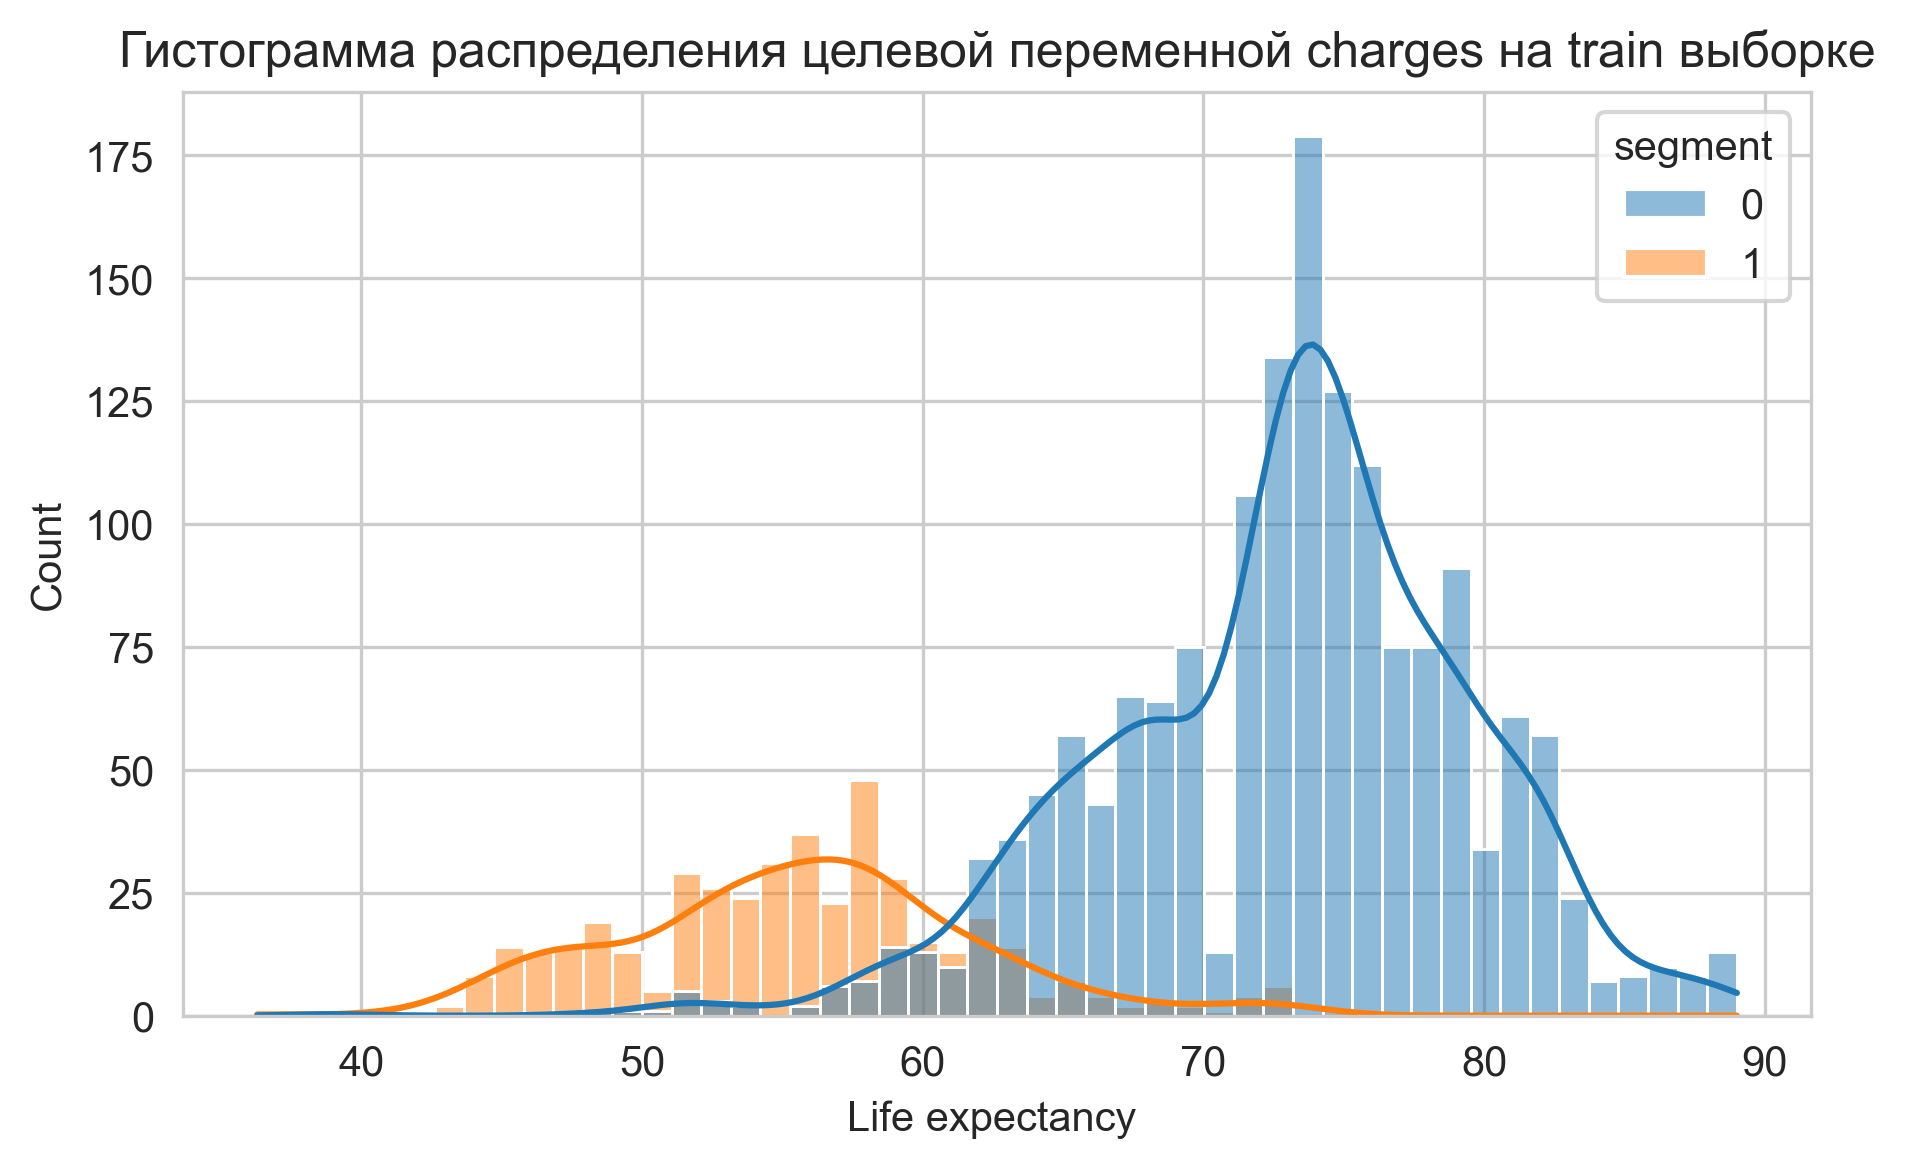

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4), dpi=300)
plt.title("Гистограмма распределения целевой переменной charges на train выборке")
sns.set_style("whitegrid")
sns.histplot(pipeline.segmented_train, x=target_col, hue='segment', bins=50, kde=True)
plt.show();

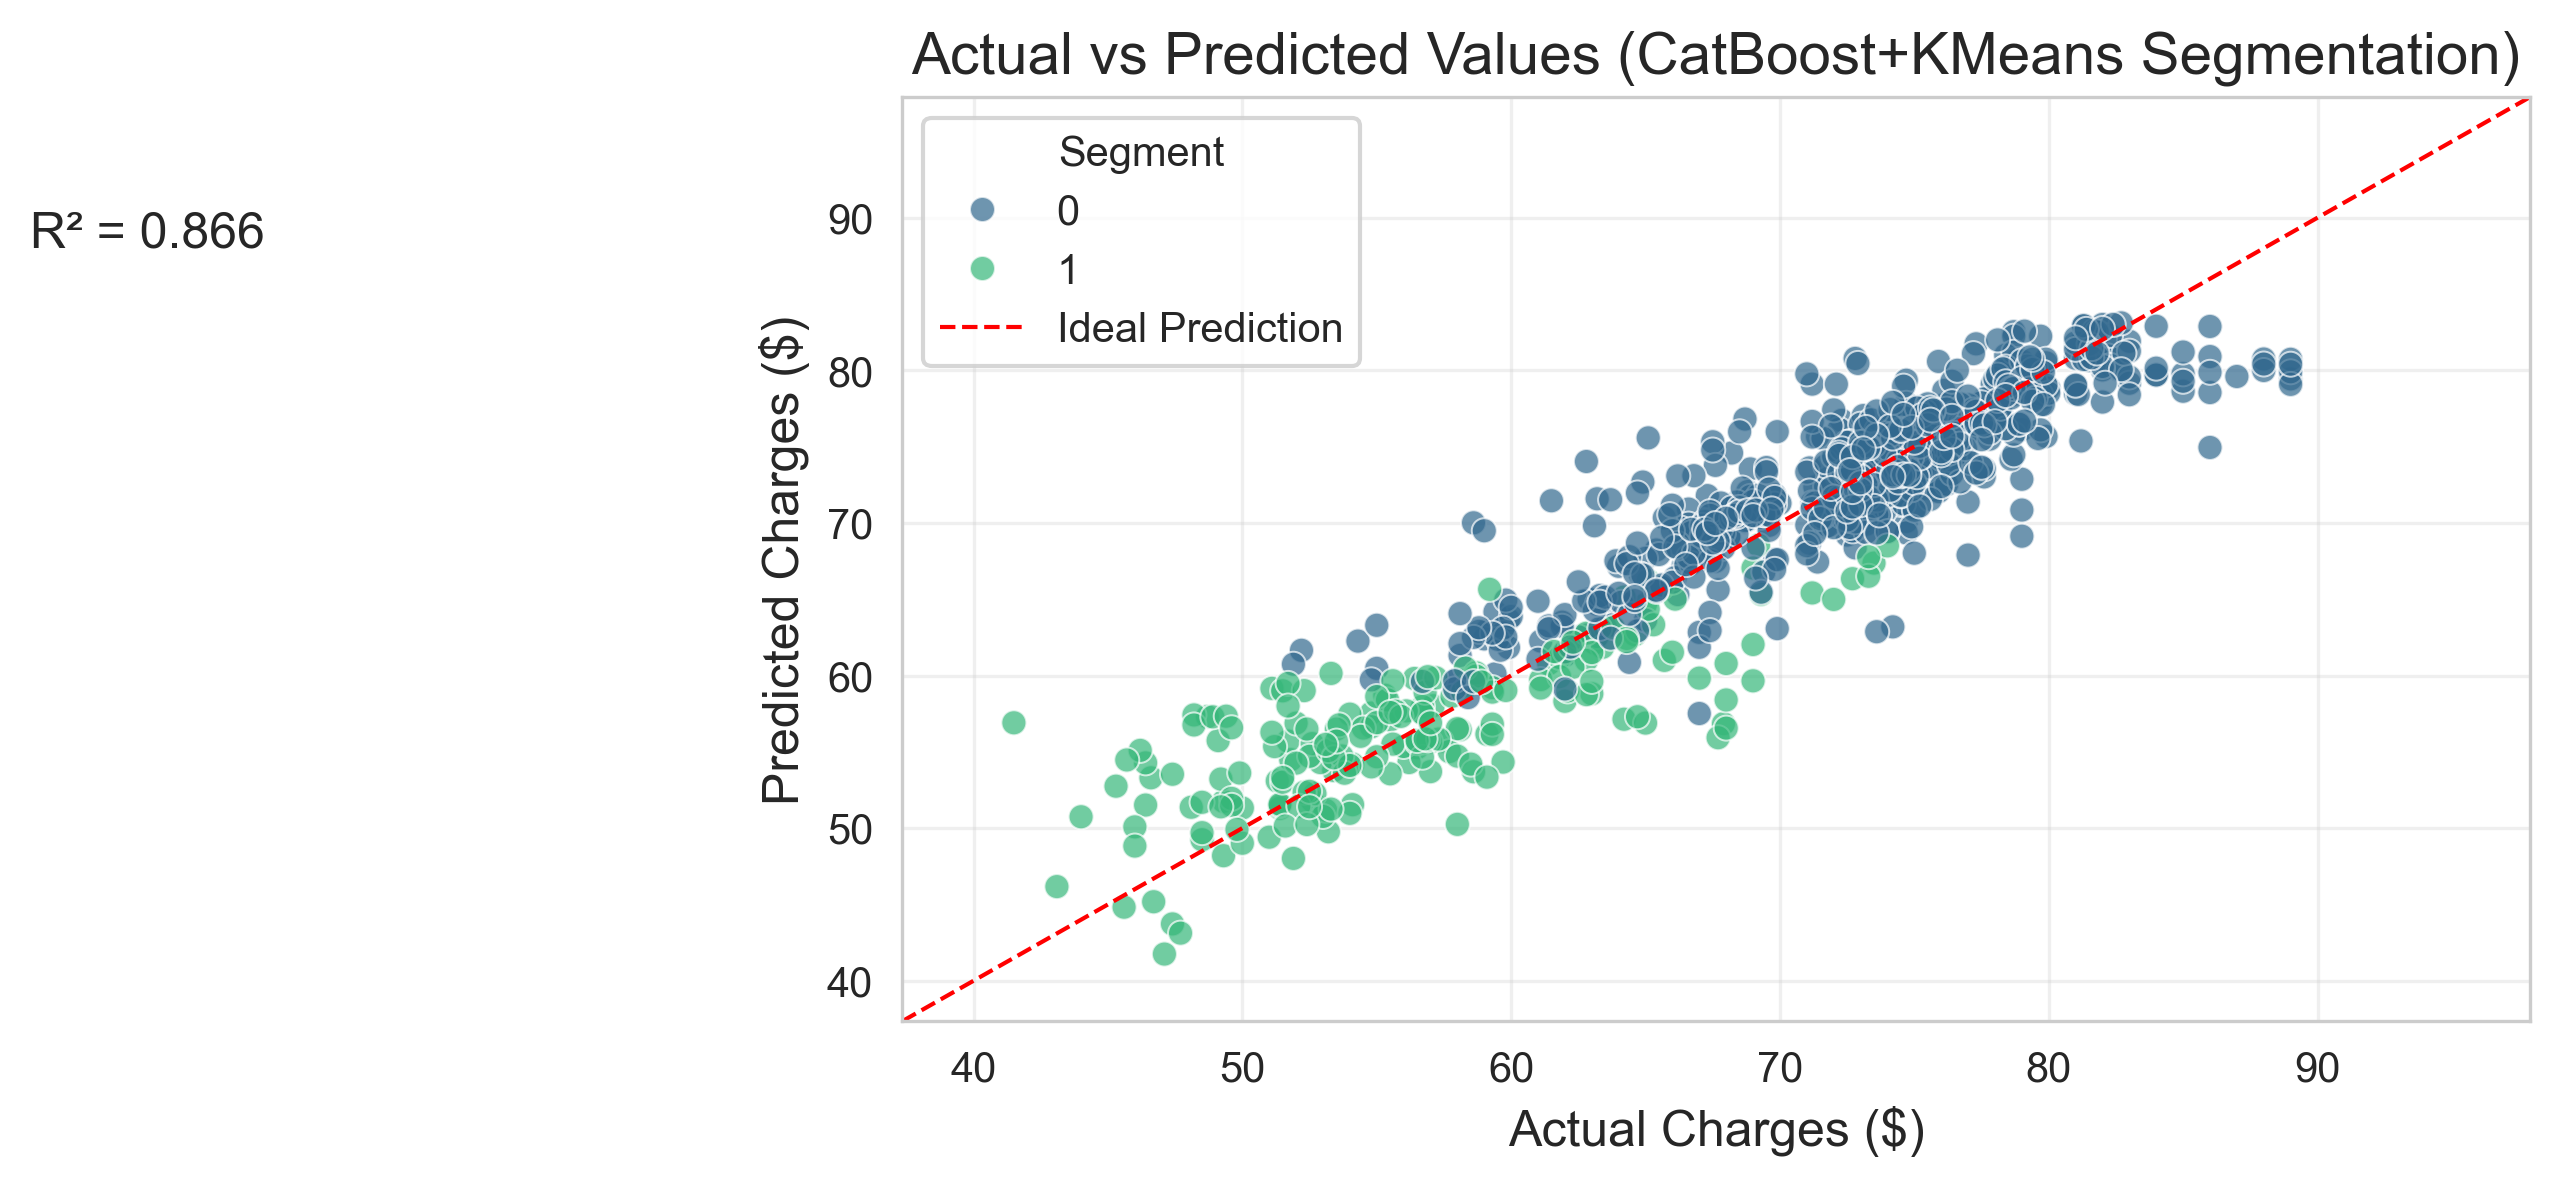

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

# Предположим, у нас есть:
# y_test - истинные значения на тестовой выборке
# y_pred - предсказания модели CatBoost+KMeans на тестовой выборке
y_test = pipeline.segmented_test[target_col]
y_pred = pipeline.regressor.predict(pipeline.segmented_test[num_features+cat_features], segments=pipeline.segmented_test['segment_preds'])

# Создаем DataFrame для визуализации
plot_data = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Segment': pipeline.segmented_test['segment']  # Добавляем информацию о сегментах
})

# Определяем границы осей (минимальное/максимальное значение + 10%)
ax_min = min(y_test.min(), y_pred.min()) * 0.9
ax_max = max(y_test.max(), y_pred.max()) * 1.1

# Создаем фигуру
plt.figure(figsize=(7, 4), dpi=300)

# Диаграмма рассеяния с цветовым кодированием по сегментам
scatter = sns.scatterplot(
    data=plot_data,
    x='Actual',
    y='Predicted',
    hue='Segment',
    palette='viridis',
    alpha=0.7
)

# Добавляем идеальную линию
ideal_line = plt.plot(
    [ax_min, ax_max],
    [ax_min, ax_max],
    '--',
    color='red',
    linewidth=1,
    label='Ideal Prediction'
)

# Настройки графика
plt.title('Actual vs Predicted Values (CatBoost+KMeans Segmentation)', fontsize=14)
plt.xlabel('Actual Charges ($)', fontsize=12)
plt.ylabel('Predicted Charges ($)', fontsize=12)
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.legend(title='Segment')
plt.grid(True, alpha=0.3)

# Добавляем коэффициент R² в аннотацию
r2 = metrics.r2_score(y_test, y_pred)
plt.text(
    x=ax_max*0.05,
    y=ax_max*0.9,
    s=f'R² = {r2:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()